In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
import requests
import json


from sklearn.linear_model import LinearRegression

#### Import Files

In [2]:
mort_data = r'C:/Users/obrienjo/Desktop/Github/UCD-project/Mortality_data.csv'
ireland_pop = r'C:/Users/obrienjo/Desktop/Github/UCD-project/Ireland Population.csv'
death_by_qtr = r'C:/Users/obrienjo/Desktop/Github/UCD-project/deaths_by_qtr.csv'

In [3]:
mort_df = pd.read_csv(mort_data)
irl_pop = pd.read_csv(ireland_pop)
qtr_death = pd.read_csv(death_by_qtr)

## Cleaning datasets
Mortality rate


In [4]:
mort_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342228 entries, 0 to 342227
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Statistic       342228 non-null  object
 1   Year            342228 non-null  int64 
 2   Age Group       342228 non-null  object
 3   Sex             342228 non-null  object
 4   Cause of Death  342228 non-null  object
 5   UNIT            342228 non-null  object
 6   VALUE           342227 non-null  object
dtypes: int64(1), object(6)
memory usage: 18.3+ MB


In [5]:
mort_df.head(10)
mort_df['Year'].max()

2017

Although the CSO file is called 1980 to 2020, the latest year repored is 2017. for this reason I have also imported qtr death rate from CSO which does not give cause of death but give death rate including 2020

In [6]:
mort_df.isna().sum()

Statistic         0
Year              0
Age Group         0
Sex               0
Cause of Death    0
UNIT              0
VALUE             1
dtype: int64

One value is NaN. rather than dropping the NaN i will inspect the dataset to see if data is recoverable

In [7]:
mort_df.fillna('check', inplace = True)
mort_df.columns

Index(['Statistic', 'Year', 'Age Group', 'Sex', 'Cause of Death', 'UNIT',
       'VALUE'],
      dtype='object')

In [8]:
mort_df.query('VALUE == "check"')

,Statistic,Year,Age Group,Sex,Cause of Death,UNIT,VALUE
313812,"Death Rate per 100,000 Population",2013,65 - 69 years,Both sexes,"Malignant neoplasm of bladderb,Rate""",5.79,check


The value in the Cause of death cell looks to be imported incorrelcty with the UNIT value concatenated with the Cause of Death value and the VALUE value in the UNIT column. i can confirm by checking the mean value of the Male individlual sexes bor same year

In [9]:
mort_df_malignant_check = pd.DataFrame(mort_df[(mort_df['Year'] == 2013) & (mort_df['Age Group'] == '65 - 69 years') & (mort_df['Cause of Death'] == 'Malignant neoplasm of bladder') & (mort_df['Statistic'] == 'Death Rate per 100,000 Population')])
mort_df_malignant_check['VALUE'] = mort_df_malignant_check['VALUE'].map(float)

In [10]:
mort_df_malignant_check

,Statistic,Year,Age Group,Sex,Cause of Death,UNIT,VALUE
313891,"Death Rate per 100,000 Population",2013,65 - 69 years,Male,Malignant neoplasm of bladder,Rate,8.43
313970,"Death Rate per 100,000 Population",2013,65 - 69 years,Female,Malignant neoplasm of bladder,Rate,3.15


In [11]:
np.mean(mort_df_malignant_check['VALUE'])

5.79

The mean is the same as the UNIT value and confirms the data value. I can replace the incorrect values with correct values

In [12]:
mort_df.at[313812,'Cause of Death']='Malignant neoplasm of bladder'
mort_df.at[313812,'UNIT'] = 'Rate'
mort_df.at[313812,'VALUE'] = 5.79

In [13]:
mort_df.query('VALUE == "check"')

,Statistic,Year,Age Group,Sex,Cause of Death,UNIT,VALUE


In [14]:
mort_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342228 entries, 0 to 342227
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Statistic       342228 non-null  object
 1   Year            342228 non-null  int64 
 2   Age Group       342228 non-null  object
 3   Sex             342228 non-null  object
 4   Cause of Death  342228 non-null  object
 5   UNIT            342228 non-null  object
 6   VALUE           342228 non-null  object
dtypes: int64(1), object(6)
memory usage: 18.3+ MB


VALUE is a object and to analyse the data I will convert the column into a float float Dtype

In [15]:
mort_df['VALUE'].replace({'-': 0 }, inplace=True)
mort_df['VALUE'] = mort_df['VALUE'].map(float)

In [16]:
mort_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342228 entries, 0 to 342227
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Statistic       342228 non-null  object 
 1   Year            342228 non-null  int64  
 2   Age Group       342228 non-null  object 
 3   Sex             342228 non-null  object 
 4   Cause of Death  342228 non-null  object 
 5   UNIT            342228 non-null  object 
 6   VALUE           342228 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 18.3+ MB


In [17]:
mort_df['UNIT'].unique()

array(['Number', 'Rate'], dtype=object)

In [18]:
mort_df_r = mort_df[mort_df['UNIT']== 'Number']

### Clean Population Data for the same time frame as mortality rates - 1980 to 2017

In [19]:
irl_pop.head(10)


,Statistic,Year,Age Group,Sex,UNIT,VALUE
0,Population Estimates (Persons in April),1950,Under 1 year,Both sexes,Thousand,61.1
1,Population Estimates (Persons in April),1950,Under 1 year,Male,Thousand,31.4
2,Population Estimates (Persons in April),1950,Under 1 year,Female,Thousand,29.7
3,Population Estimates (Persons in April),1950,0 - 4 years,Both sexes,Thousand,NaN
4,Population Estimates (Persons in April),1950,0 - 4 years,Male,Thousand,NaN
5,Population Estimates (Persons in April),1950,0 - 4 years,Female,Thousand,NaN
6,Population Estimates (Persons in April),1950,0 - 14 years,Both sexes,Thousand,851.2
7,Population Estimates (Persons in April),1950,0 - 14 years,Male,Thousand,434.6
8,Population Estimates (Persons in April),1950,0 - 14 years,Female,Thousand,416.6
9,Population Estimates (Persons in April),1950,1 - 4 years,Both sexes,Thousand,249.1


In [20]:
irl_pop.isna().sum()

Statistic      0
Year           0
Age Group      0
Sex            0
UNIT           0
VALUE        114
dtype: int64

In [21]:


irl_pop_NA = irl_pop[irl_pop['VALUE'].isna()]




In [22]:
irl_pop_NA['Age Group'].unique()

array(['0 - 4 years'], dtype=object)

Only one age group is missing population data '0 - 4 years'
I will subset the population data by year to match the mortility rate dataset. Then i will check the list of years that the VALUE is Nan for the '0 - 4 years' agegroup

In [23]:
irl_pop_80_17 = irl_pop[(irl_pop['Year'] >= 1980) & (irl_pop['Year'] <=2017)]
irl_pop_80_17.isna().sum()
irl_pop_80_17_na = irl_pop_80_17[irl_pop_80_17['VALUE'].isna()]
irl_pop_80_17_yearsna = irl_pop_80_17['Year'][irl_pop_80_17['VALUE'].isna()]
year_list_missing_data = list(irl_pop_80_17_yearsna.unique())
print(year_list_missing_data)
    

[1980, 1982, 1983, 1984, 1985, 1987, 1988, 1989, 1990, 1992, 1993, 1994, 1995]


In [24]:
irl_pop_80_17_na['Age Group'].unique()


array(['0 - 4 years'], dtype=object)

### Rather than dropping data, i will look at the 5 - 9 age grouo for the years where there is data for 0 - 4 agegroup and check if there is a strong corelation 

Age Group    0
Statistic    0
Year         0
Sex          0
UNIT         0
VALUE        0
dtype: int64
0.8136002776506115


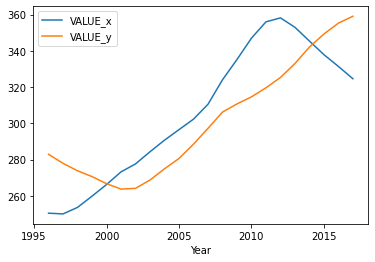

In [25]:
irl_pop_95_17 = irl_pop_80_17[(irl_pop_80_17['Year'] > 1995) &(irl_pop_80_17['Year'] <=2017) & (irl_pop_80_17['Sex'] == 'Both sexes') ]

indexset = irl_pop_95_17.reset_index(drop = True).set_index('Age Group')

irl_pop_95_17_0to4 = indexset.loc['0 - 4 years'].reset_index(drop = False)
irl_pop_95_17_5to9 = indexset.loc['5 - 9 years'].reset_index(drop = False)


print(irl_pop_95_17_0to4.isna().sum())

irl_pop_95_17_0to4['VALUE'] = irl_pop_95_17_0to4['VALUE'].map(float)
irl_pop_95_17_5to9['VALUE'] = irl_pop_95_17_5to9['VALUE'].map(float)
df_0to4 = pd.DataFrame(irl_pop_95_17_0to4)
df_5to9 = pd.DataFrame(irl_pop_95_17_5to9)


df3 = df_0to4.merge(df_5to9, on = 'Year')
df3.columns
correlation = df3['VALUE_x'].corr(df3['VALUE_y'])
print(correlation)

df3.plot(x ='Year', y=['VALUE_x','VALUE_y'], kind = 'line')
plt.show()


There is a strong correlation between the agegroups. I will create a regression model for the years that I have data on both age groups and using the model predict the population for the 0-4 agegroups using the 5 - 9 agegroups as the predictor

In [26]:
model = LinearRegression()
x = np.array(df3['VALUE_x']).reshape((-1, 1))
y = np.array(df3['VALUE_y'])
model.fit(x, y)
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)
print(model.intercept_ + model.coef_ * 250)


coefficient of determination: 0.6619454117931518
intercept: 88.43637012082363
slope: [0.69550222]
[262.31192592]


In [27]:
irl_pop_80_17 = pd.DataFrame(irl_pop_80_17)
print(irl_pop_80_17)
irl_pop_80_17.iloc[3,5]

                                    Statistic  Year          Age Group  \
2430  Population Estimates (Persons in April)  1980       Under 1 year   
2431  Population Estimates (Persons in April)  1980       Under 1 year   
2432  Population Estimates (Persons in April)  1980       Under 1 year   
2433  Population Estimates (Persons in April)  1980        0 - 4 years   
2434  Population Estimates (Persons in April)  1980        0 - 4 years   
...                                       ...   ...                ...   
5503  Population Estimates (Persons in April)  2017  85 years and over   
5504  Population Estimates (Persons in April)  2017  85 years and over   
5505  Population Estimates (Persons in April)  2017           All ages   
5506  Population Estimates (Persons in April)  2017           All ages   
5507  Population Estimates (Persons in April)  2017           All ages   

             Sex      UNIT   VALUE  
2430  Both sexes  Thousand    72.5  
2431        Male  Thousand    37.4  


nan

Using iterrows we will complete the following
1. replace the Nan with 'check'
2. if the row value is check, add to a list the index of the check location
3. identify the year and Sex of the missing value
4. subset the data to identify the corresponding year and sex of the 5 to 9 year old of the missing value of 0 to 4 year old
5. Use the regression model equation with the 5 to 9 year old age and append to a new age list
6. create a list of the range of the length of the new_age list to use as index values
7. loop through the list to replace the NaN values in the dataframe with the new age 



In [28]:

irl_pop_80_17.fillna('check', inplace = True)
new_age_list = []
index_list = []
for l, row in irl_pop_80_17.iterrows():    
    if row['VALUE'] == 'check':
        index = irl_pop_80_17.index.get_loc(l)
        index = int(index)
        index_list.append(index)
        
        #index=irl_pop_80_17.index
        #ref_index = index[row['VALUE']=='check']
        
        year = row['Year']
        sex = row['Sex']
        age = '5 - 9 years'
        indexset = irl_pop_80_17.reset_index(drop = True).set_index(['Year', 'Sex', 'Age Group'])
        regressionx = indexset['VALUE'].loc[(year, sex, age)]
        new_age = (model.intercept_ + model.coef_ * regressionx)
        new_age = int(new_age)      
        new_age_list.append(new_age)
        
        irl_pop_80_17.iloc[index,5] == new_age
        #row['VALUE'].replace({'check': new_age }, inplace=True)
new_age_list = np.array(new_age_list).flatten()
print(new_age_list)
print(index_list)        

index_list_range = list(range(len(index_list)))
for i in index_list_range:
     irl_pop_80_17.iloc[index_list[i],5] = new_age_list[i]
irl_pop_80_17.head(10)        

[331 212 207 332 213 207 333 214 207 333 214 208 333 214 207 333 213 207
 331 212 206 326 210 203 317 205 199 304 199 193 298 196 190 292 193 187
 288 190 185]
[3, 4, 5, 165, 166, 167, 246, 247, 248, 327, 328, 329, 408, 409, 410, 570, 571, 572, 651, 652, 653, 732, 733, 734, 813, 814, 815, 975, 976, 977, 1056, 1057, 1058, 1137, 1138, 1139, 1218, 1219, 1220]


,Statistic,Year,Age Group,Sex,UNIT,VALUE
2430,Population Estimates (Persons in April),1980,Under 1 year,Both sexes,Thousand,72.5
2431,Population Estimates (Persons in April),1980,Under 1 year,Male,Thousand,37.4
2432,Population Estimates (Persons in April),1980,Under 1 year,Female,Thousand,35.1
2433,Population Estimates (Persons in April),1980,0 - 4 years,Both sexes,Thousand,331
2434,Population Estimates (Persons in April),1980,0 - 4 years,Male,Thousand,212
2435,Population Estimates (Persons in April),1980,0 - 4 years,Female,Thousand,207
2436,Population Estimates (Persons in April),1980,0 - 14 years,Both sexes,Thousand,1035.4
2437,Population Estimates (Persons in April),1980,0 - 14 years,Male,Thousand,530.6
2438,Population Estimates (Persons in April),1980,0 - 14 years,Female,Thousand,504.9
2439,Population Estimates (Persons in April),1980,1 - 4 years,Both sexes,Thousand,275.2


In [29]:
irl_pop_80_17.info()
irl_pop_80_17['UNIT'].unique()
irl_pop_80_17['Population'] = irl_pop_80_17['VALUE'] * 1000

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3078 entries, 2430 to 5507
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Statistic  3078 non-null   object
 1   Year       3078 non-null   int64 
 2   Age Group  3078 non-null   object
 3   Sex        3078 non-null   object
 4   UNIT       3078 non-null   object
 5   VALUE      3078 non-null   object
dtypes: int64(1), object(5)
memory usage: 232.9+ KB


In [30]:
irl_pop_80_17_m = irl_pop_80_17[['Year', 'Age Group', 'Sex', 'Population']]

In [31]:
mort_df_r.columns
mort_df_r.shape

(171114, 7)

Clean quarterly data

In [32]:
print(qtr_death.isna().sum())
print(qtr_death.info())

STATISTIC         0
Statistic         0
TLIST(Q1)         0
Quarter           0
VSAGES            0
Age at Death      0
UNIT              0
VALUE           474
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3675 entries, 0 to 3674
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   STATISTIC     3675 non-null   object 
 1   Statistic     3675 non-null   object 
 2   TLIST(Q1)     3675 non-null   int64  
 3   Quarter       3675 non-null   object 
 4   VSAGES        3675 non-null   int64  
 5   Age at Death  3675 non-null   object 
 6   UNIT          3675 non-null   object 
 7   VALUE         3201 non-null   float64
dtypes: float64(1), int64(2), object(5)
memory usage: 229.8+ KB
None


In [33]:
qtr_death.head(10)

,STATISTIC,Statistic,TLIST(Q1),Quarter,VSAGES,Age at Death,UNIT,VALUE
0,VSAQ2,Deaths Registered Provisional,19601,1960Q1,1,Under 1 Year,Number,507.0
1,VSAQ2,Deaths Registered Provisional,19601,1960Q1,11,4 Weeks to 1 Year,Number,NaN
2,VSAQ2,Deaths Registered Provisional,19601,1960Q1,12,1 Week to 4 Weeks,Number,NaN
3,VSAQ2,Deaths Registered Provisional,19601,1960Q1,13,Under 7 Days,Number,NaN
4,VSAQ2,Deaths Registered Provisional,19601,1960Q1,131,1 to 7 Days,Number,NaN
5,VSAQ2,Deaths Registered Provisional,19601,1960Q1,132,Under 1 Day,Number,NaN
6,VSAQ2,Deaths Registered Provisional,19601,1960Q1,2,1 to 4 Years,Number,94.0
7,VSAQ2,Deaths Registered Provisional,19601,1960Q1,3,5 to 14 Years,Number,73.0
8,VSAQ2,Deaths Registered Provisional,19601,1960Q1,4,15 to 24 Years,Number,56.0
9,VSAQ2,Deaths Registered Provisional,19601,1960Q1,5,25 to 34 Years,Number,100.0


In [34]:
qtr_death['Year'] = qtr_death['Quarter'].str[:4]

In [35]:
qtr_death.head(10)

,STATISTIC,Statistic,TLIST(Q1),Quarter,VSAGES,Age at Death,UNIT,VALUE,Year
0,VSAQ2,Deaths Registered Provisional,19601,1960Q1,1,Under 1 Year,Number,507.0,1960
1,VSAQ2,Deaths Registered Provisional,19601,1960Q1,11,4 Weeks to 1 Year,Number,NaN,1960
2,VSAQ2,Deaths Registered Provisional,19601,1960Q1,12,1 Week to 4 Weeks,Number,NaN,1960
3,VSAQ2,Deaths Registered Provisional,19601,1960Q1,13,Under 7 Days,Number,NaN,1960
4,VSAQ2,Deaths Registered Provisional,19601,1960Q1,131,1 to 7 Days,Number,NaN,1960
5,VSAQ2,Deaths Registered Provisional,19601,1960Q1,132,Under 1 Day,Number,NaN,1960
6,VSAQ2,Deaths Registered Provisional,19601,1960Q1,2,1 to 4 Years,Number,94.0,1960
7,VSAQ2,Deaths Registered Provisional,19601,1960Q1,3,5 to 14 Years,Number,73.0,1960
8,VSAQ2,Deaths Registered Provisional,19601,1960Q1,4,15 to 24 Years,Number,56.0,1960
9,VSAQ2,Deaths Registered Provisional,19601,1960Q1,5,25 to 34 Years,Number,100.0,1960


In [36]:
qtr_death['Year'] = qtr_death['Year'].map(int)

indexset = qtr_death.reset_index(drop = False).set_index('Year')
pop_qtr_18to20 = indexset.loc[[2018,2019,2020]].reset_index(drop = False)


pop_qtr_18to20['UNIT'].unique()
pop_qtr_18to20.isna().sum()

year_list = list(range(1980,2021))
#year_listb = []
#for i in year_list:
#    str(i)
#    year_listb.append(i)
qtr_death['Year'] = qtr_death['Year'].map(int)
pop_qtr_80to20 = qtr_death[(qtr_death['Year'] >= 1980) & (qtr_death['Year'] <= 2020)]
#indexset = qtr_death.reset_index(drop = False).set_index('Year').sort_values(by='Year')
#pop_qtr_80to20 = indexset.loc[].reset_index(drop = False)
print(pop_qtr_80to20)


    

     STATISTIC                      Statistic  TLIST(Q1) Quarter  VSAGES  \
1200     VSAQ2  Deaths Registered Provisional      19801  1980Q1       1   
1201     VSAQ2  Deaths Registered Provisional      19801  1980Q1      11   
1202     VSAQ2  Deaths Registered Provisional      19801  1980Q1      12   
1203     VSAQ2  Deaths Registered Provisional      19801  1980Q1      13   
1204     VSAQ2  Deaths Registered Provisional      19801  1980Q1     131   
...        ...                            ...        ...     ...     ...   
3655     VSAQ2  Deaths Registered Provisional      20204  2020Q4       6   
3656     VSAQ2  Deaths Registered Provisional      20204  2020Q4       7   
3657     VSAQ2  Deaths Registered Provisional      20204  2020Q4       8   
3658     VSAQ2  Deaths Registered Provisional      20204  2020Q4       9   
3659     VSAQ2  Deaths Registered Provisional      20204  2020Q4      10   

           Age at Death    UNIT   VALUE  Year  
1200       Under 1 Year  Number   215.0

In [37]:
pop_qtr_18to20[pop_qtr_18to20['VALUE'].isna()]


,Year,index,STATISTIC,Statistic,TLIST(Q1),Quarter,VSAGES,Age at Death,UNIT,VALUE
75,2019,3555,VSAQ2,Deaths Registered Provisional,20192,2019Q2,1,Under 1 Year,Number,NaN
90,2019,3570,VSAQ2,Deaths Registered Provisional,20193,2019Q3,1,Under 1 Year,Number,NaN


In [38]:
pop_qtr_18to20['VALUE'].fillna(0, inplace = True)

pop_qtr_18to20.isna().sum()
print(qtr_death.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3675 entries, 0 to 3674
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   STATISTIC     3675 non-null   object 
 1   Statistic     3675 non-null   object 
 2   TLIST(Q1)     3675 non-null   int64  
 3   Quarter       3675 non-null   object 
 4   VSAGES        3675 non-null   int64  
 5   Age at Death  3675 non-null   object 
 6   UNIT          3675 non-null   object 
 7   VALUE         3201 non-null   float64
 8   Year          3675 non-null   int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 258.5+ KB
None


In [39]:
pop_18to20_group = pop_qtr_18to20.groupby('Year')['VALUE'].sum().reset_index()
pop_18to20_group = pd.DataFrame(pop_18to20_group)
pop_18to20_group['colour'] = 'G'
pop_18to20_group.rename(columns={'Year': 'Year', 'VALUE': 'VALUE'}, inplace=True)
pop_18to20_group.head()

,Year,VALUE,colour
0,2018,31858.0,G
1,2019,31342.0,G
2,2020,31979.0,G


### Join population and mortality df

In [40]:
new_mort_df = pd.merge(mort_df_r,irl_pop_80_17_m, how = 'left', left_on =['Year', 'Age Group', 'Sex'], right_on = ['Year', 'Age Group', 'Sex'], suffixes = ('_mort', '_pop'))

In [41]:
new_mort_df.shape



(171114, 8)

In [42]:
new_mort_df.head(10)
new_mort_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171114 entries, 0 to 171113
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Statistic       171114 non-null  object 
 1   Year            171114 non-null  int64  
 2   Age Group       171114 non-null  object 
 3   Sex             171114 non-null  object 
 4   Cause of Death  171114 non-null  object 
 5   UNIT            171114 non-null  object 
 6   VALUE           171114 non-null  float64
 7   Population      171114 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 11.7+ MB


In [43]:
new_mort_df['Death_Percent'] = (new_mort_df['VALUE']/new_mort_df['Population']) * 100
new_mort_df_Summary = new_mort_df[(new_mort_df['Age Group'] == 'All ages') & (new_mort_df['Sex'] == 'Both sexes') & (new_mort_df['Cause of Death'] == 'All causes of death')]


<AxesSubplot:title={'center':'Total Deaths Per Annum'}, xlabel=' Year', ylabel='Total Deaths'>

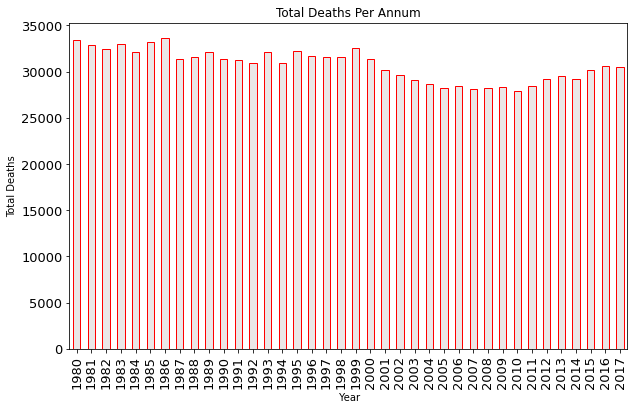

In [44]:
new_mort_df_Summary_group = new_mort_df_Summary.groupby('Year')['VALUE'].sum()
new_mort_df_Summary_group.plot(kind = 'bar', title = 'Total Deaths Per Annum', ylabel = 'Total Deaths', xlabel = ' Year', figsize = (10,6), color =(0.2, 0.1, 0.1, 0.1),  edgecolor='red', fontsize = 13)
                       

In [45]:
new_mort_df_Summary_group = pd.DataFrame(new_mort_df_Summary_group).reset_index()
new_mort_df_Summary_group['colour'] = 'B'
new_mort_df_Summary_group.rename(columns={'Year': 'Year', '0': 'VALUE'}, inplace=True)

new_mort_df_Summary_group.head()


,Year,VALUE,colour
0,1980,33472.0,B
1,1981,32929.0,B
2,1982,32457.0,B
3,1983,32976.0,B
4,1984,32076.0,B


In [46]:
joint_year_DR = pd.concat([new_mort_df_Summary_group, pop_18to20_group], join = 'inner').reset_index(drop = True)


In [47]:
joint_year_DR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    41 non-null     int64  
 1   VALUE   41 non-null     float64
 2   colour  41 non-null     object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.1+ KB


In [48]:
print(joint_year_DR)

    Year    VALUE colour
0   1980  33472.0      B
1   1981  32929.0      B
2   1982  32457.0      B
3   1983  32976.0      B
4   1984  32076.0      B
5   1985  33213.0      B
6   1986  33626.0      B
7   1987  31413.0      B
8   1988  31580.0      B
9   1989  32111.0      B
10  1990  31370.0      B
11  1991  31305.0      B
12  1992  30931.0      B
13  1993  32148.0      B
14  1994  30948.0      B
15  1995  32259.0      B
16  1996  31723.0      B
17  1997  31581.0      B
18  1998  31563.0      B
19  1999  32608.0      B
20  2000  31391.0      B
21  2001  30212.0      B
22  2002  29683.0      B
23  2003  29074.0      B
24  2004  28665.0      B
25  2005  28260.0      B
26  2006  28488.0      B
27  2007  28117.0      B
28  2008  28274.0      B
29  2009  28380.0      B
30  2010  27961.0      B
31  2011  28456.0      B
32  2012  29186.0      B
33  2013  29504.0      B
34  2014  29252.0      B
35  2015  30127.0      B
36  2016  30667.0      B
37  2017  30484.0      B
38  2018  31858.0      G


<AxesSubplot:xlabel='Year'>

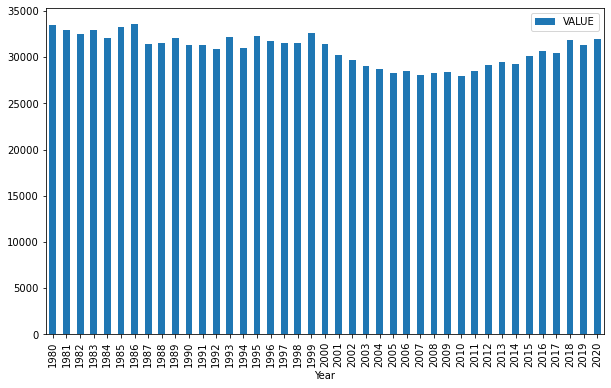

In [49]:
joint_year_DR.plot('Year','VALUE', kind = 'bar', figsize = (10,6))

<AxesSubplot:title={'center':'Population by Year'}, xlabel=' Year', ylabel='Population'>

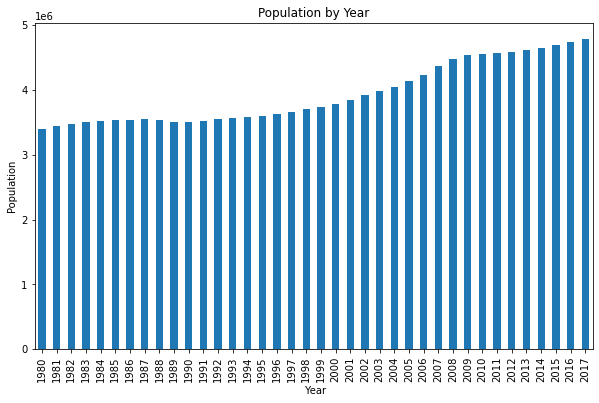

In [50]:
new_mort_df_Summary_group = new_mort_df_Summary.groupby('Year')['Population'].sum()
new_mort_df_Summary_group.plot(kind = 'bar', title = 'Population by Year', ylabel = 'Population', xlabel = ' Year', figsize = (10,6))


,Statistic,Year,Age Group,Sex,Cause of Death,UNIT,VALUE,Population,Death_Percent
0,Deaths,1980,0 - 4 years,Both sexes,All causes of death,Number,1006.0,331000,0.303927
1,Deaths,1980,0 - 4 years,Both sexes,Infectious and parasitic diseases,Number,38.0,331000,0.01148
2,Deaths,1980,0 - 4 years,Both sexes,Tuberculosis,Number,0.0,331000,0.0
3,Deaths,1980,0 - 4 years,Both sexes,Meningococcal infection,Number,14.0,331000,0.00423
4,Deaths,1980,0 - 4 years,Both sexes,Aids (HIV disease),Number,0.0,331000,0.0
5,Deaths,1980,0 - 4 years,Both sexes,Viral hepatitis,Number,0.0,331000,0.0
6,Deaths,1980,0 - 4 years,Both sexes,All other infectious and parasitic diseases,Number,24.0,331000,0.007251
7,Deaths,1980,0 - 4 years,Both sexes,Neoplasms,Number,16.0,331000,0.004834
8,Deaths,1980,0 - 4 years,Both sexes,Malignant neoplasms,Number,16.0,331000,0.004834
9,Deaths,1980,0 - 4 years,Both sexes,"Malignant neoplasm of lip, oral cavity, pharynx",Number,0.0,331000,0.0


In [51]:

def keyword_search (search_word):
    list_of_key = []   
    search = search_word
    d = '(?!$)' + search + '(?!$)'
    key = new_mort_df['Cause of Death'].str.lower()[new_mort_df['Cause of Death'].str.lower().str.contains(d)].unique()
    list_of_key.append(key)
    list_of_key = np.array(list_of_key).flatten()
    print (list_of_key)
    #print(list(new_mort_df['Age Group'].unique()))
    return (list_of_key)

In [52]:
my_query = keyword_search('meni')
#keyword_search('car')
#print(list_of_key)


['meningococcal infection' 'meningitis']


### meningitis related deaths
add sort to list


In [53]:
def categorised_data (query, age_group):
    indexset = new_mort_df.reset_index(drop = False).set_index('Age Group')
    sorted_mort_df = indexset.loc[age_group].reset_index(drop = False)
    sorted_mort_df['Cause of Death'] = sorted_mort_df['Cause of Death'].str.lower()    
    sorted_mort_df = sorted_mort_df.reset_index(drop = False).set_index('Cause of Death')
    new_sorted_mort_df = sorted_mort_df.loc[query].reset_index(drop = False)
    return new_sorted_mort_df

In [56]:
meningitis_df  = categorised_data(my_query,'All ages')

<AxesSubplot:title={'center':'Total Deaths Per Annum due to Meningitis related'}, xlabel=' Year', ylabel='Total Deaths'>

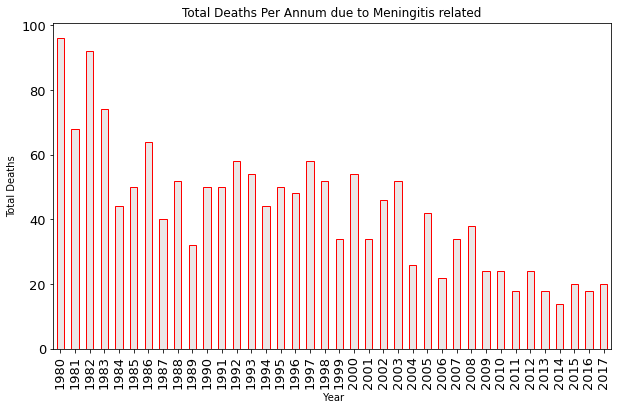

In [58]:
meningitis_df_summary = meningitis_df.groupby('Year')['VALUE'].sum()
meningitis_df_summary.plot(kind = 'bar', title = 'Total Deaths Per Annum due to Meningitis related', ylabel = 'Total Deaths', xlabel = ' Year', figsize = (10,6), color =(0.2, 0.1, 0.1, 0.1),  edgecolor='red', fontsize = 13)

In [71]:
my_query2 = keyword_search('hepatit')

['viral hepatitis']


In [75]:
viral_hepatitis_df  = categorised_data(my_query2,'All ages')

<AxesSubplot:title={'center':'Total Deaths Per Annum due to Viral hepatitis related'}, xlabel=' Year', ylabel='Total Deaths'>

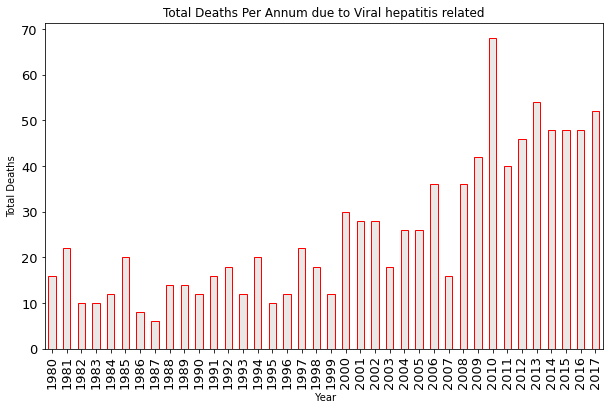

In [77]:
viral_hepatitis_df_summary = viral_hepatitis_df.groupby('Year')['VALUE'].sum()
viral_hepatitis_df_summary.plot(kind = 'bar', title = 'Total Deaths Per Annum due to Viral hepatitis related', ylabel = 'Total Deaths', xlabel = ' Year', figsize = (10,6), color =(0.2, 0.1, 0.1, 0.1),  edgecolor='red', fontsize = 13)

In [81]:
my_query3 = keyword_search('self')
suicide_df  = categorised_data(my_query3,'All ages')

['suicide and intentional self harm']


<AxesSubplot:title={'center':'Total Deaths Per Annum due Suicide related'}, xlabel=' Year', ylabel='Total Deaths'>

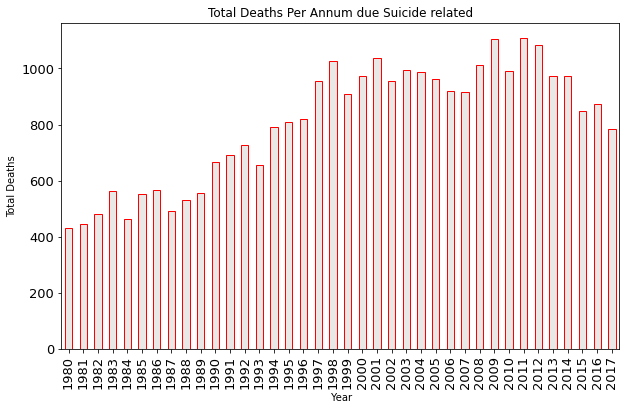

In [83]:
suicide_df_summary = suicide_df.groupby('Year')['VALUE'].sum()
suicide_df_summary.plot(kind = 'bar', title = 'Total Deaths Per Annum due Suicide related', ylabel = 'Total Deaths', xlabel = ' Year', figsize = (10,6), color =(0.2, 0.1, 0.1, 0.1),  edgecolor='red', fontsize = 13)

In [94]:
my_query4 = keyword_search('trans')
trasnport_accidents  = categorised_data(my_query4,'All ages')

['transport accidents']


<AxesSubplot:title={'center':'Total Deaths Per Annum due Suicide related'}, xlabel=' Year', ylabel='Total Deaths'>

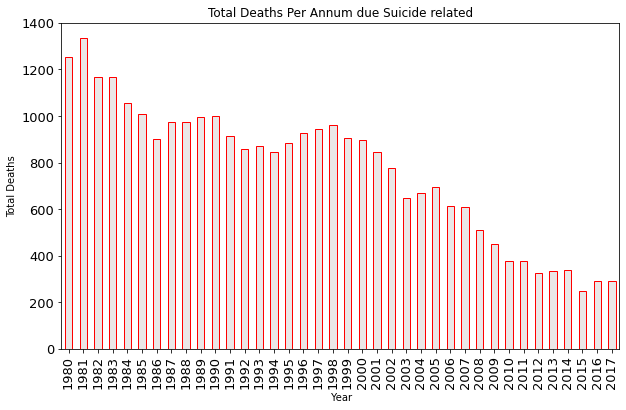

In [95]:
trasnport_accidents_df_summary = trasnport_accidents.groupby('Year')['VALUE'].sum()
trasnport_accidents_df_summary.plot(kind = 'bar', title = 'Total Deaths Per Annum due Suicide related', ylabel = 'Total Deaths', xlabel = ' Year', figsize = (10,6), color =(0.2, 0.1, 0.1, 0.1),  edgecolor='red', fontsize = 13)